<a href="https://colab.research.google.com/github/CasCard/Machine-Learning-Project/blob/master/TransferLearning_withTFHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers


In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}


In [0]:
IMAGE_SHAPE=(224,224)
classifier=tf.keras.Sequential([
      hub.KerasLayer(classifier_url,input_shape=IMAGE_SHAPE+(3,))
])

65536/61306 [================================] - 0s 0us/step


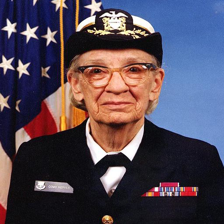

In [4]:
import numpy as np
import PIL.Image as Image

grace_hopper=tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper=Image.open(grace_hopper).resize(IMAGE_SHAPE)
grace_hopper

In [5]:
grace_hopper=np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [6]:
result=classifier.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [7]:
predicted_class=np.argmax(result[0],axis=-1)
predicted_class

653

In [8]:
labels_path=tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels=np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


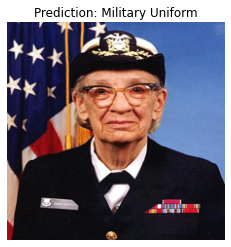

In [9]:
plt.imshow(grace_hopper)
plt.axis("off")
predicted_class_name=imagenet_labels[predicted_class]
_ = plt.title("Prediction: "+predicted_class_name.title())

In [10]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)


228818944/228813984 [==============================] - 3s 0us/step


In [11]:
image_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data=image_generator.flow_from_directory(str(data_root),target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [12]:
for image_batch,label_batch in image_data:
  print("Image batch shape: ",image_batch.shape)
  print("Label batch shape: ",label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [13]:
result_batch=classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [14]:
predicted_class_names=imagenet_labels[np.argmax(result_batch,axis=-1)]
predicted_class_names

array(['daisy', 'daisy', 'cardoon', 'vase', 'hip', 'daisy', 'conch',
       'daisy', 'clog', 'balloon', 'velvet', 'vase', 'ashcan',
       'picket fence', 'sea urchin', 'banana', "yellow lady's slipper",
       'cardoon', 'cardoon', 'cardoon', 'daisy', 'bell pepper', 'daisy',
       'daisy', 'hummingbird', 'bee', 'daisy', 'bee', 'daisy', 'vase',
       'sea urchin', 'daisy'], dtype='<U30')

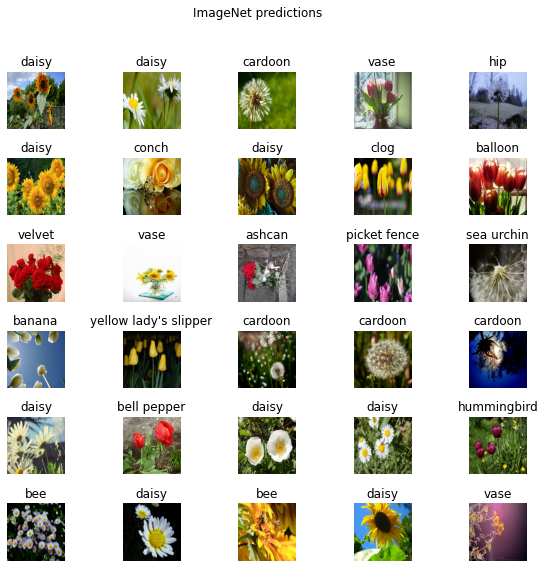

In [15]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}


In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))


In [18]:
feature_batch=feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor_layer.trainable = False

In [20]:
model = tf.keras.Sequential([
                             feature_extractor_layer,
                             layers.Dense(image_data.num_classes)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
predictions=model(image_batch)
predictions.shape

TensorShape([32, 5])

In [0]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses=[]
    self.batch_acc=[]

  def on_train_batch_end(self,batch,logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [25]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)
batch_stats_callback=CollectBatchStats()
history=model.fit_generator(image_data,epochs=2,
                            steps_per_epoch=steps_per_epoch,
                            callbacks=[batch_stats_callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/2
115/115 [==============================] - 12s 106ms/step - loss: 0.3182 - acc: 0.8438
Epoch 2/2
115/115 [==============================] - 12s 104ms/step - loss: 0.3555 - acc: 0.9062


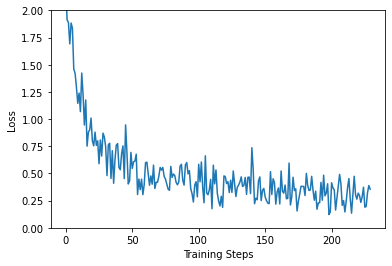

In [26]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

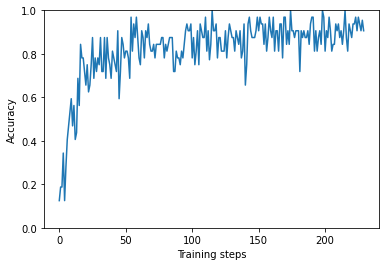

In [27]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [28]:
class_names=sorted(image_data.class_indices.items(),key=lambda pair:pair[1])
class_names=np.array([key.title() for key,value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [0]:
predicted_batch=model.predict(image_batch)
predicted_id = np.argmax(predicted_batch,axis=-1)
predicted_label_batch = class_names[predicted_id]

In [0]:
label_id = np.argmax(label_batch,axis=-1)

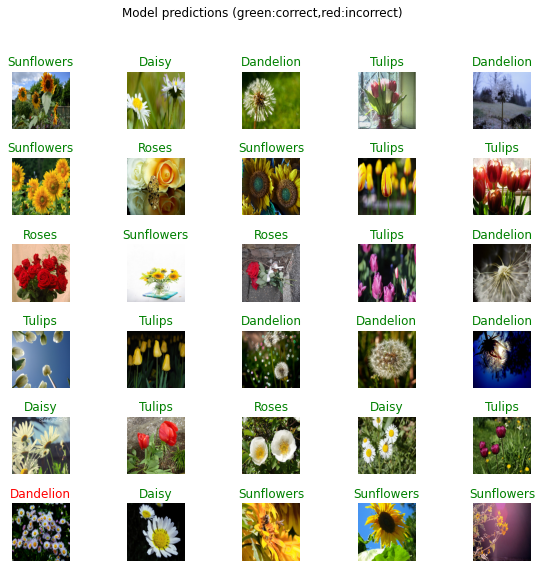

In [31]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(),color=color)
  plt.axis("off")
_ = plt.suptitle("Model predictions (green:correct,red:incorrect)")

In [32]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path,save_format='tf')

export_path

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: /tmp/saved_models/1585497335/assets


INFO:tensorflow:Assets written to: /tmp/saved_models/1585497335/assets


'/tmp/saved_models/1585497335'

In [0]:
reloaded = tf.keras.models.load_model(export_path)
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [0]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [35]:
abs(reloaded_result_batch-reloaded_result_batch).max()

0.0